In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [2]:

# Load the rainfall and ground water level data for 2 years
data = pd.read_csv('Input/rf_api_90days.csv',index_col='date', usecols=['date','rainfall','gwl'])

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


FileNotFoundError: [Errno 2] No such file or directory: 'Input/rf_api_90days.csv'

In [9]:

# Split the data into training and testing sets
train_size = int(len(data_scaled) * 0.67) # 0.67 == 2/3 of data set,i.e 2 out of 3
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

print(train_data.shape)
print(test_data.shape)

(468, 2)
(231, 2)


In [20]:

# Reshape the data for LSTM input for converting from 2D to 3D array
train_X = np.reshape(train_data[:, :-1], (train_data.shape[0], train_data.shape[1] - 1, 1))
test_X = np.reshape(test_data[:, :-1], (test_data.shape[0], test_data.shape[1] - 1, 1))
train_Y = train_data[:, -1]
test_Y = test_data[:, -1]
# print(train_X.shape)
# print(test_X.shape)


In [23]:

# Define the LSTM model
model = Sequential()
input_shp=(train_X.shape[1],train_X.shape[2])

model.add(LSTM(4, input_shape=input_shp, return_sequences=True))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(train_X, train_Y, epochs=50, batch_size=1, verbose=2)

test_predict = model.predict(test_X)

print(test_predict.shape)
print(test_Y.shape)


Epoch 1/50


/Users/devikasivakumar/trial/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


468/468 - 1s - 2ms/step - loss: 0.8903
Epoch 2/50
468/468 - 0s - 339us/step - loss: 0.7785
Epoch 3/50
468/468 - 0s - 337us/step - loss: 0.6807
Epoch 4/50
468/468 - 0s - 337us/step - loss: 0.6484
Epoch 5/50
468/468 - 0s - 336us/step - loss: 0.6429
Epoch 6/50
468/468 - 0s - 335us/step - loss: 0.6410
Epoch 7/50
468/468 - 0s - 336us/step - loss: 0.6391
Epoch 8/50
468/468 - 0s - 337us/step - loss: 0.6368
Epoch 9/50
468/468 - 0s - 337us/step - loss: 0.6351
Epoch 10/50
468/468 - 0s - 338us/step - loss: 0.6343
Epoch 11/50
468/468 - 0s - 340us/step - loss: 0.6333
Epoch 12/50
468/468 - 0s - 347us/step - loss: 0.6321
Epoch 13/50
468/468 - 0s - 357us/step - loss: 0.6305
Epoch 14/50
468/468 - 0s - 340us/step - loss: 0.6287
Epoch 15/50
468/468 - 0s - 338us/step - loss: 0.6277
Epoch 16/50
468/468 - 0s - 348us/step - loss: 0.6273
Epoch 17/50
468/468 - 0s - 350us/step - loss: 0.6256
Epoch 18/50
468/468 - 0s - 352us/step - loss: 0.6238
Epoch 19/50
468/468 - 0s - 408us/step - loss: 0.6226
Epoch 20/50
468

In [12]:
out_Y = [val[0] for val in test_predict]
out_Y = np.array(out_Y)
print(out_Y.shape)


(231,)


In [13]:

print(test_Y[0], out_Y[0])
for i in range(10):
    print(test_Y[i],out_Y[i])


-0.6977099114830976 -0.009719856
-0.6977099114830976 -0.009719856
-0.7462671535754007 -0.8093714
-0.6491526693907926 -0.009719856
-0.5617496336246451 -0.009719856
-0.5617496336246451 -0.009719856
-0.5520381852061844 -0.22108328
-0.41607790734773203 -0.15184695
-0.4063664589292714 -0.009719856
-0.4063664589292714 -0.009719856
-0.3189634231631239 -0.009719856


In [24]:

#reshape test_y
test_Y= np.reshape(test_Y,(231,1,1))
print(test_Y.shape)

#combine the text_x and text_y 
observed= np.array((test_X, test_Y)).T
print(observed.shape)


(231, 1, 1)
(1, 1, 231, 2)


In [15]:

#reshape out_y
out_Y= np.reshape(out_Y,(231,1,1))
print(out_Y.shape)

#combine test_Y and out_y
predict= np.array((test_X,out_Y)).T
print(predict.shape)


(231, 1, 1)
(1, 1, 231, 2)


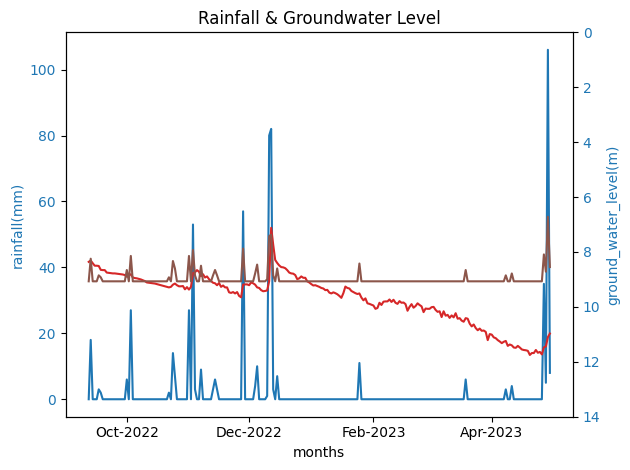

In [19]:

# Reshape predict to a 2D array
predict = predict.reshape(-1, predict.shape[-1])
observed = observed.reshape(-1, observed.shape[-1])
# Now you can use inverse_transform without any issues

#plt.plot(scaler.inverse_transform(predict, observed))
predict_unscaled = scaler.inverse_transform(predict)
observed_unscaled = scaler.inverse_transform(observed)

df = pd.DataFrame()
df['rainfall'] = data['rainfall'][train_size:len(data)]
df['gwl_obs'] = observed_unscaled[:, 1]
df['gwl_prd'] = predict_unscaled[:, 1]
#print(df)

import matplotlib.dates as dates


fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('months')
ax1.set_ylabel('rainfall(mm)', color=color)
date_set = pd.to_datetime(df.index, format='%d/%m/%Y')


# ax1.plot(t, data1, color=color)
ax1.plot(date_set, df['rainfall'], color=color, label='ground water level')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(dates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(dates.DateFormatter('%b-%Y'))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('ground_water_level(m)', color=color)  # we already handled the x-label with ax1
ax2.plot(date_set, df['gwl_obs'], color='tab:red')
ax2.plot(date_set, df['gwl_prd'], color='tab:brown')
ax2.set_ylim(14, 0)
ax2.tick_params(axis='y', labelcolor=color)


plt.title('Rainfall & Groundwater Level')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# save the output file
plt.savefig('Output/plot/lstm_rf_gwl.png')

plt.show()
